In [1]:
import warnings
warnings.filterwarnings('ignore')   # <--- don't forget to remove this

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
import category_encoders as ce
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
from lightgbm import plot_importance, LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

In [2]:
data = 'data/winequality-white.csv'
#bins = [0, 4, 7, 10]
#labels = ['low', 'medium', 'high']
#df['quality_category'] = pd.cut(df['quality'], bins=bins, labels=labels, include_lowest=True) <- this is for classification but I did not use it

df = pd.read_csv(data, delimiter=';')

X = df.drop('quality', axis=1)
y = df['quality']

In [3]:
print(df.head())
print(df.tail())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [4]:
X

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
4                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  
0         8.8  
1         9.5  
2        10.1  
3         9.9  
4         9.9  
...       ...  
4893     11.2  
4894      9.6  
4895      9.4  
4896     12.8  
4897     11.8  

[4898 rows x 11 columns]

In [5]:
y

0       6
1       6
2       6
3       6
4       6
       ..
4893    6
4894    5
4895    6
4896    7
4897    6
Name: quality, Length: 4898, dtype: int64

In [6]:
print(df.head())
print(df.describe())
print(df.info())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

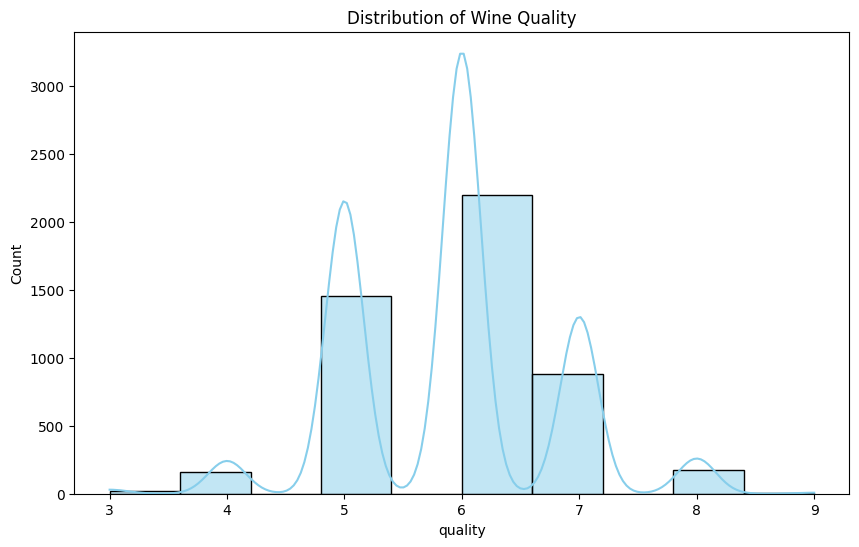

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['quality'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Wine Quality')
plt.show()


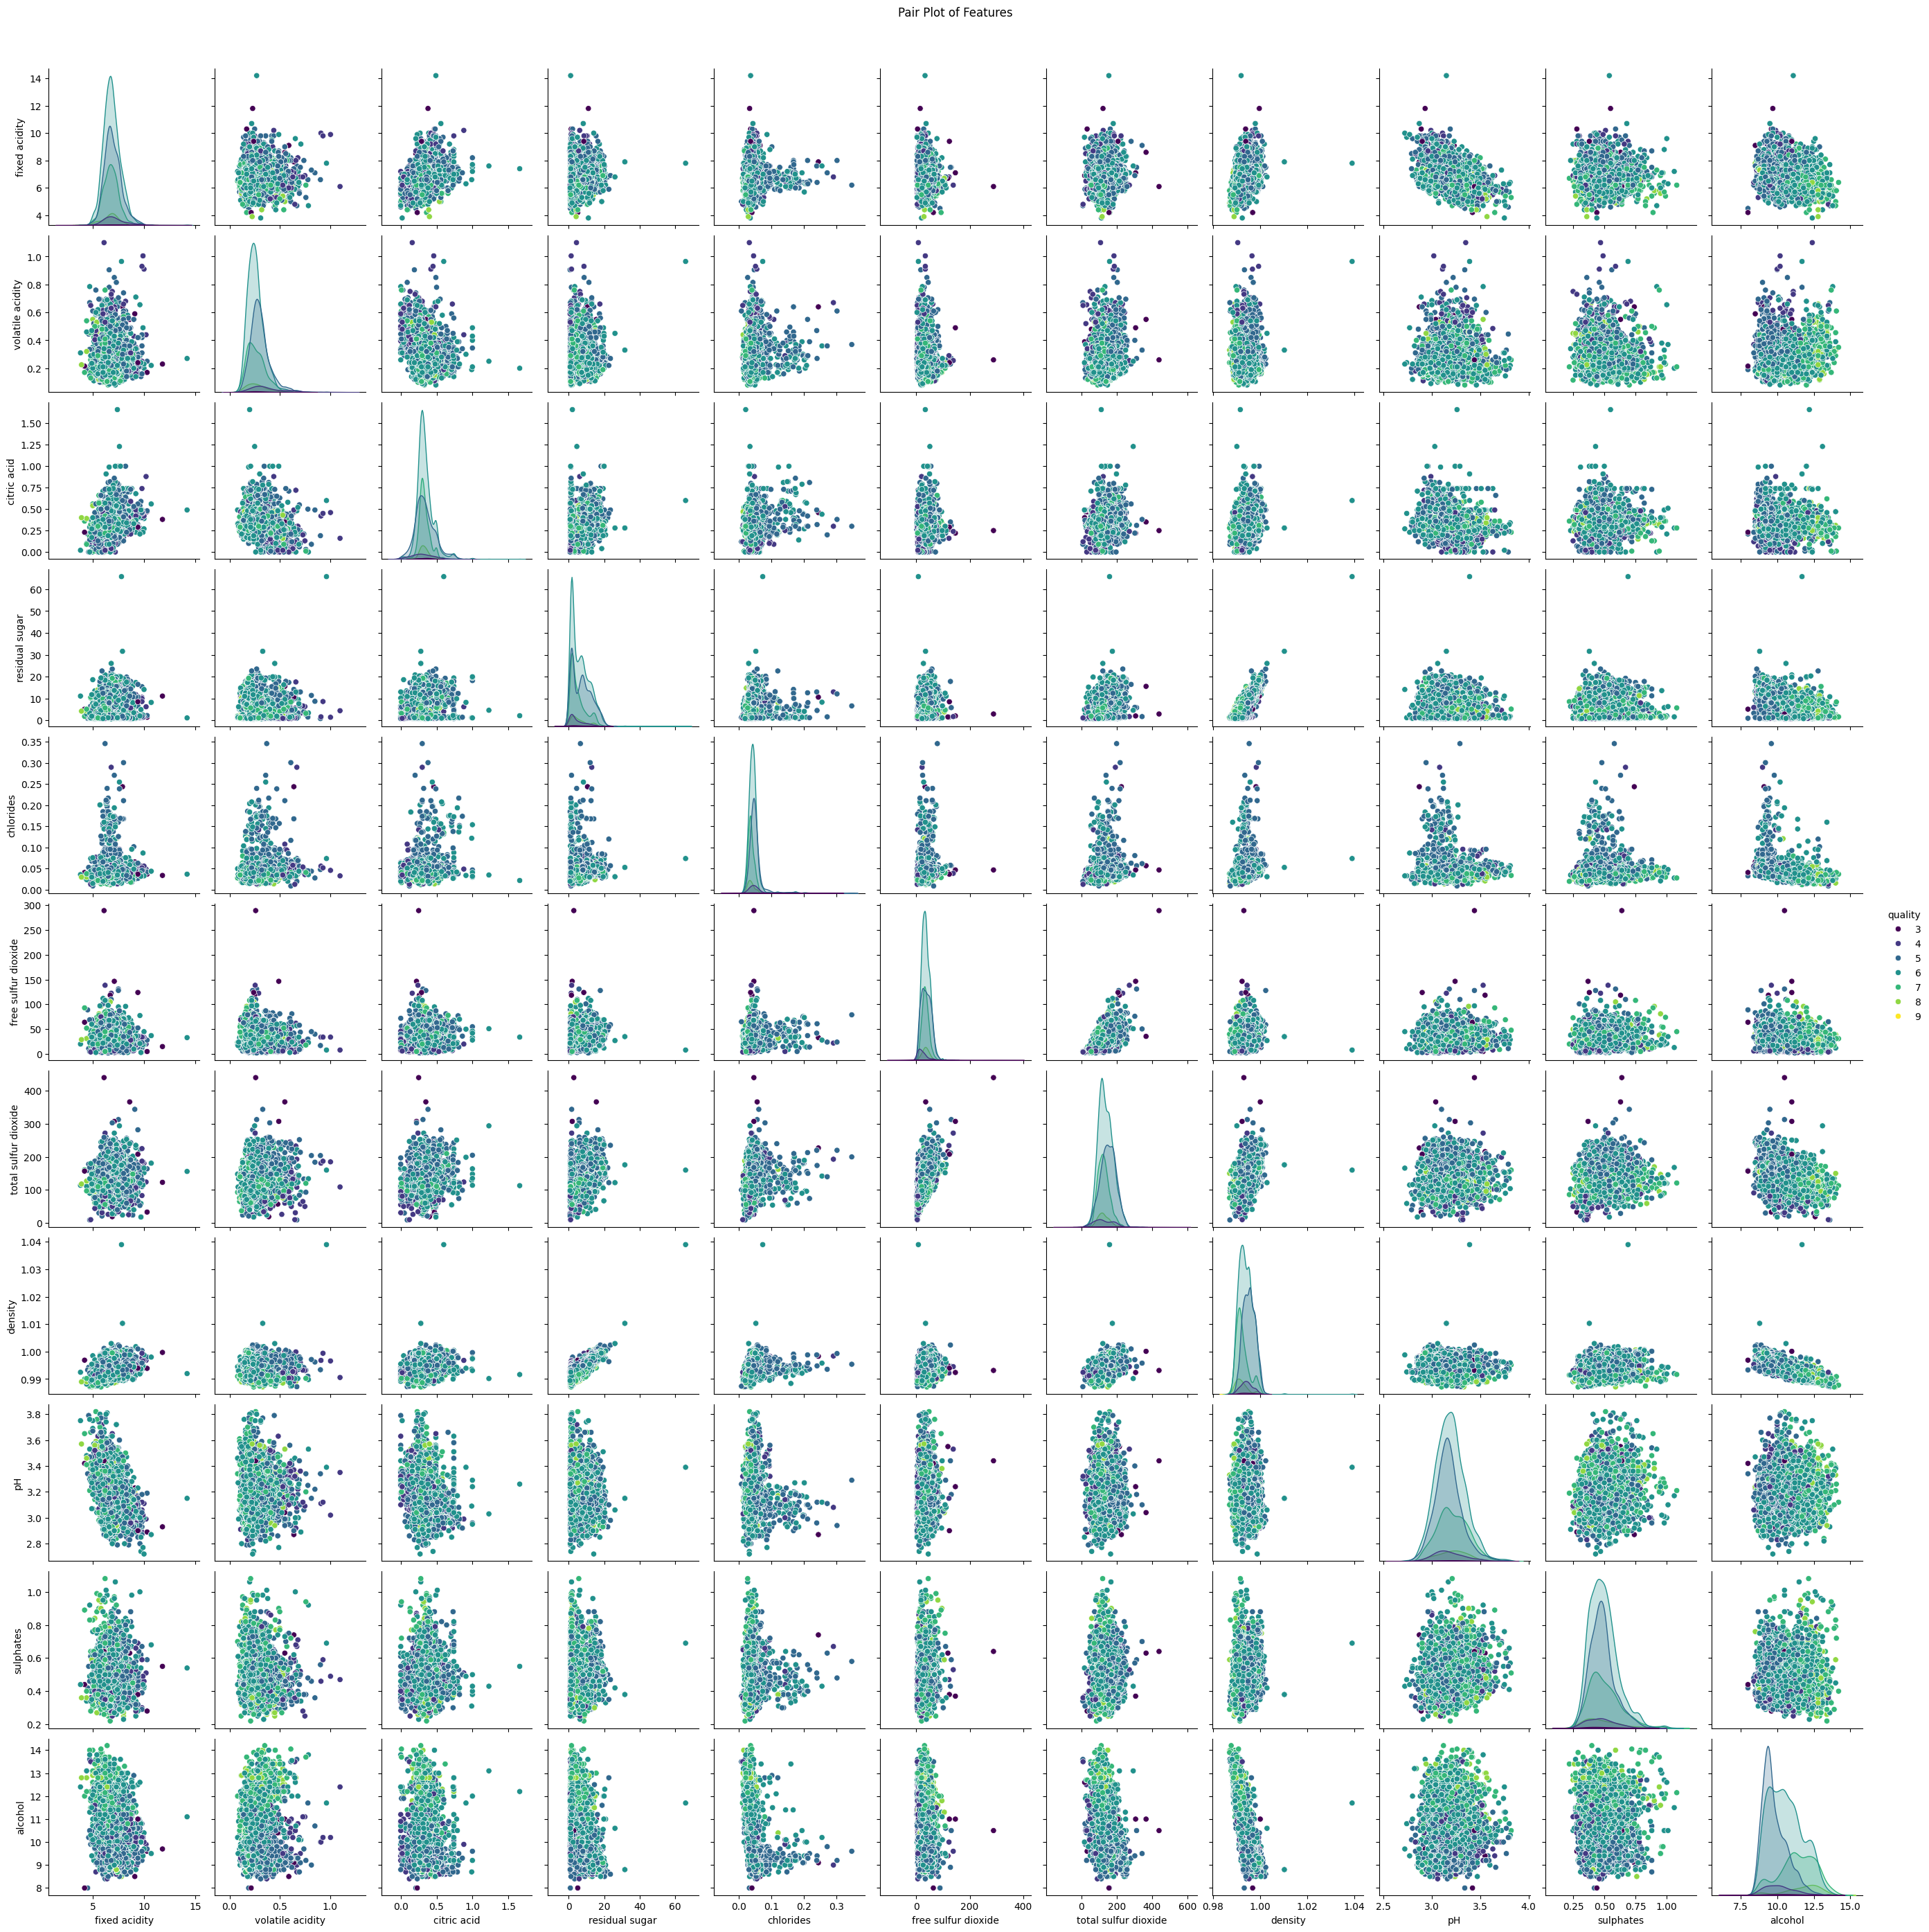

In [8]:
sns.pairplot(df, hue='quality', markers='o', palette='viridis', vars=df.columns[:-1])   # <--- this takes forever. fix it.
plt.suptitle('Pair Plot of Features', y=1.02)
plt.show()

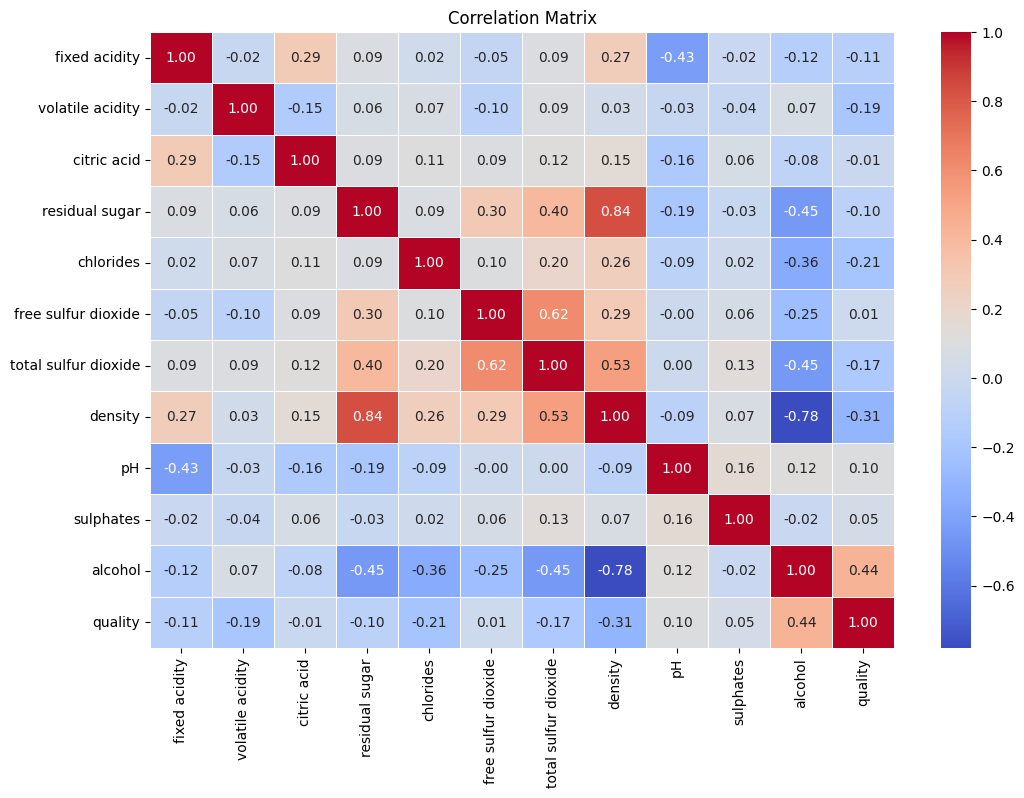

In [9]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

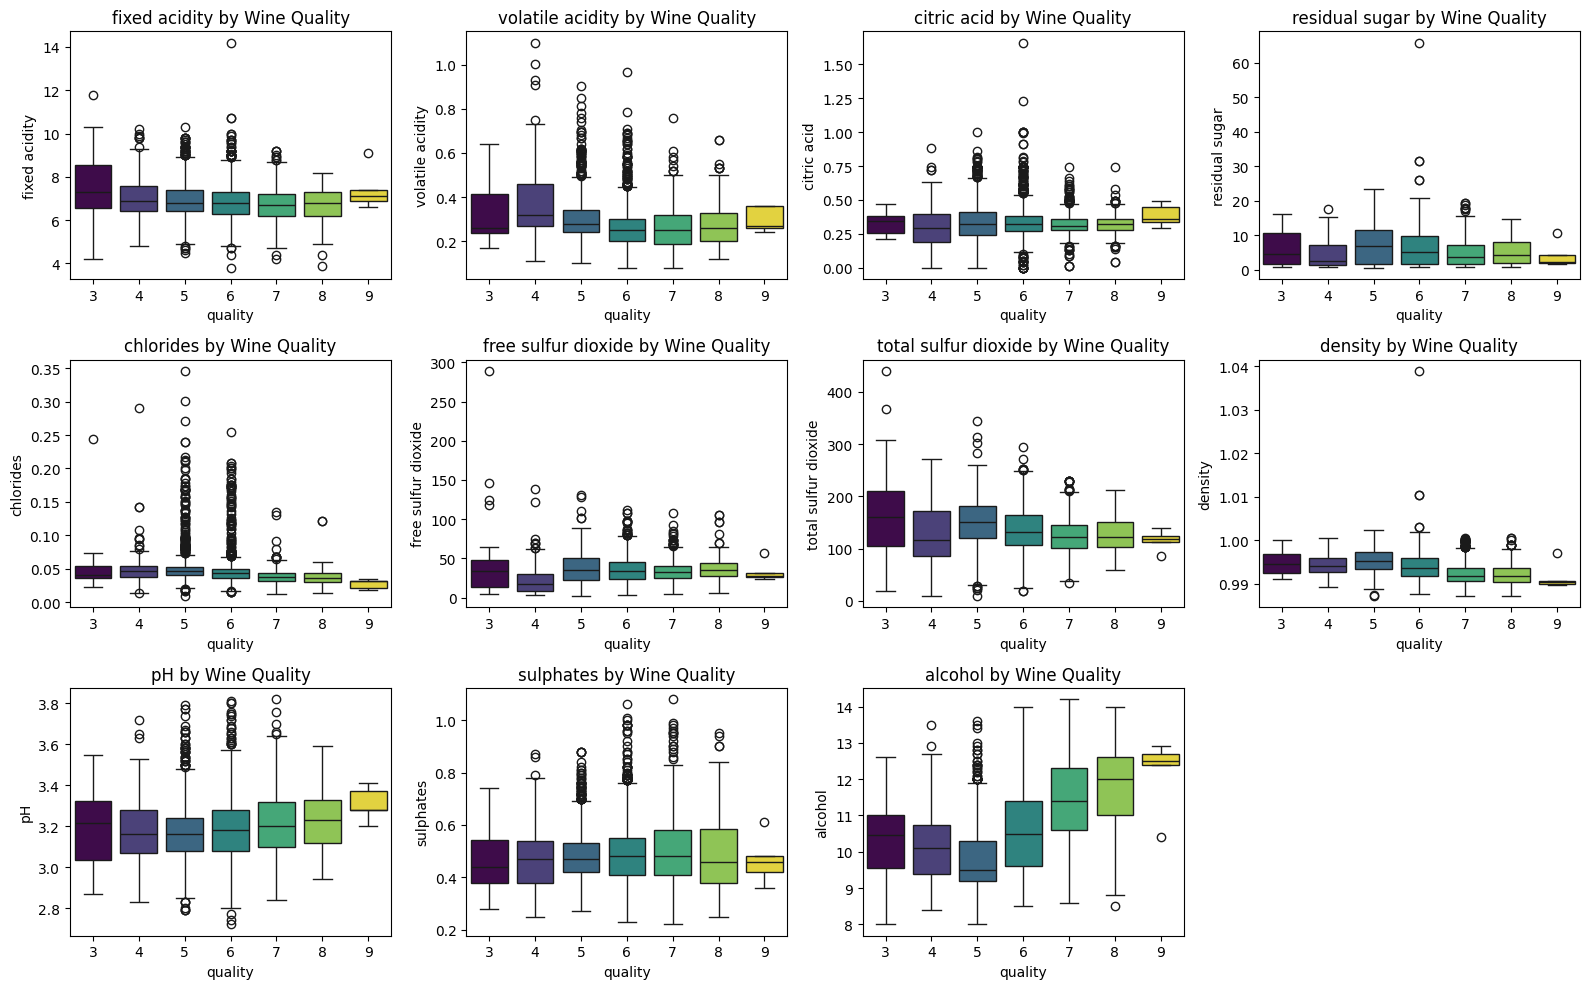

In [10]:
if 'df' not in globals():
    print("Please run cell 1 to define the dataframe 'df'")
else:
    plt.figure(figsize=(16, 10))
    for i, column in enumerate(df.columns[:-1]):
        plt.subplot(3, 4, i+1)
        sns.boxplot(x='quality', y=column, data=df, hue='quality', palette='viridis', legend=False)
        plt.title(f'{column} by Wine Quality')
    plt.tight_layout()
    plt.show()


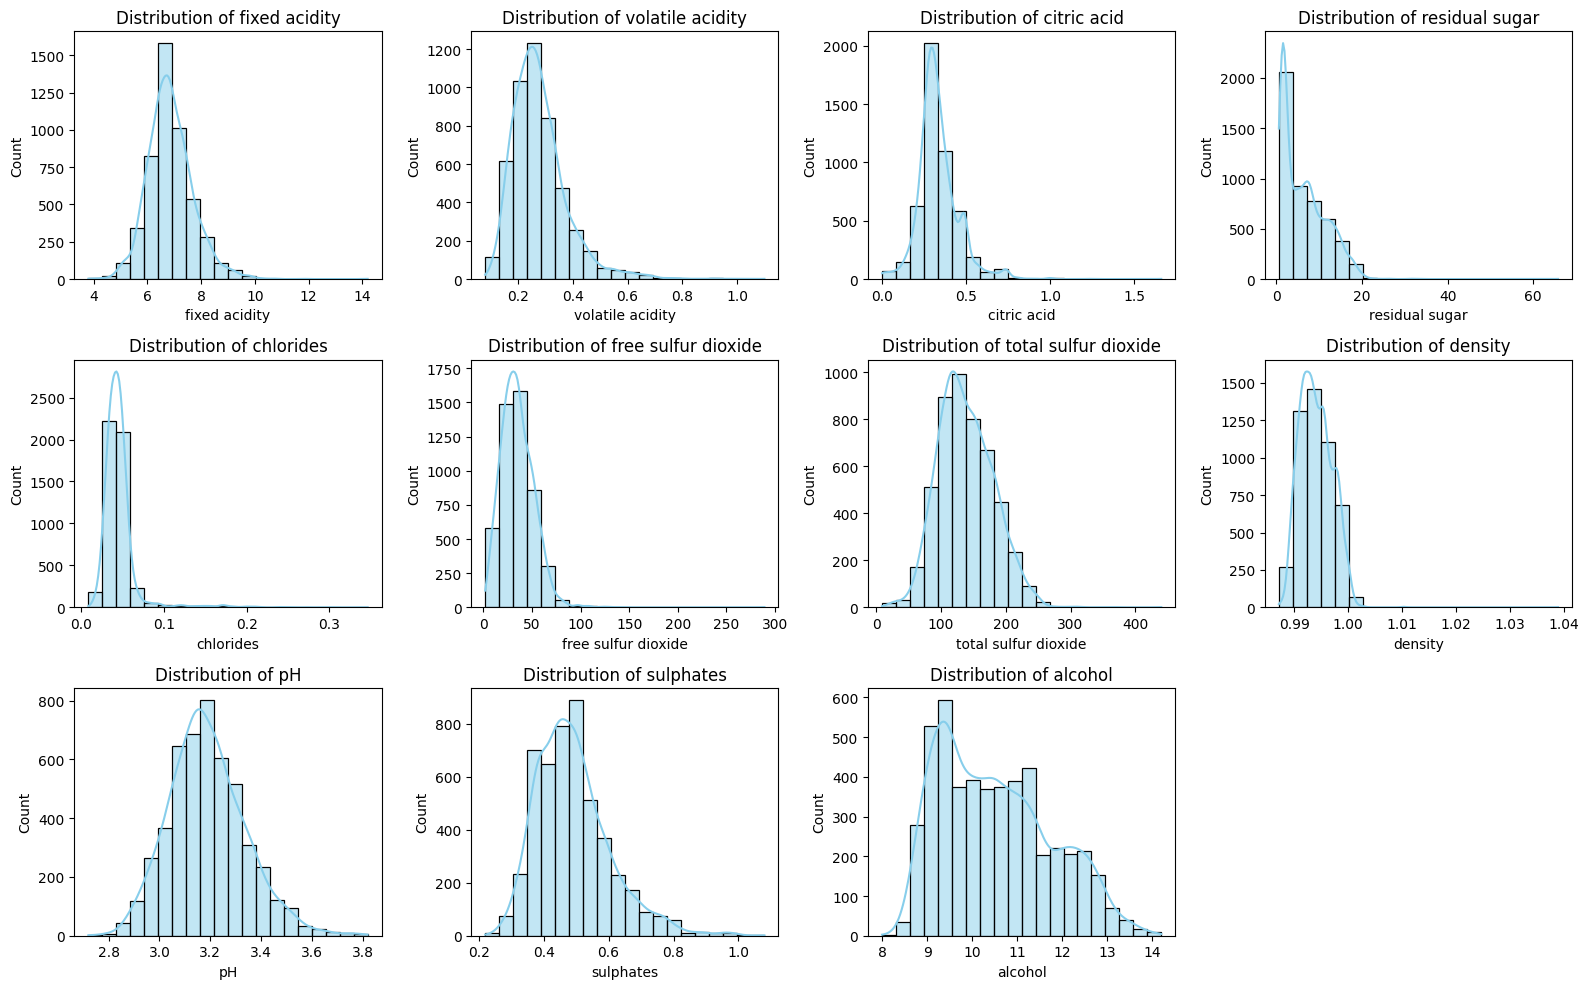

In [11]:
plt.figure(figsize=(16, 10))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[column], bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [12]:
feature_stats = X.describe().transpose()
print(feature_stats)

                       count        mean        std      min         25%  \
fixed acidity         4898.0    6.854788   0.843868  3.80000    6.300000   
volatile acidity      4898.0    0.278241   0.100795  0.08000    0.210000   
citric acid           4898.0    0.334192   0.121020  0.00000    0.270000   
residual sugar        4898.0    6.391415   5.072058  0.60000    1.700000   
chlorides             4898.0    0.045772   0.021848  0.00900    0.036000   
free sulfur dioxide   4898.0   35.308085  17.007137  2.00000   23.000000   
total sulfur dioxide  4898.0  138.360657  42.498065  9.00000  108.000000   
density               4898.0    0.994027   0.002991  0.98711    0.991723   
pH                    4898.0    3.188267   0.151001  2.72000    3.090000   
sulphates             4898.0    0.489847   0.114126  0.22000    0.410000   
alcohol               4898.0   10.514267   1.230621  8.00000    9.500000   

                            50%       75%        max  
fixed acidity           6.80000 

In [13]:
print(df.isnull().sum())
df.fillna(df.mean(), inplace=True)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


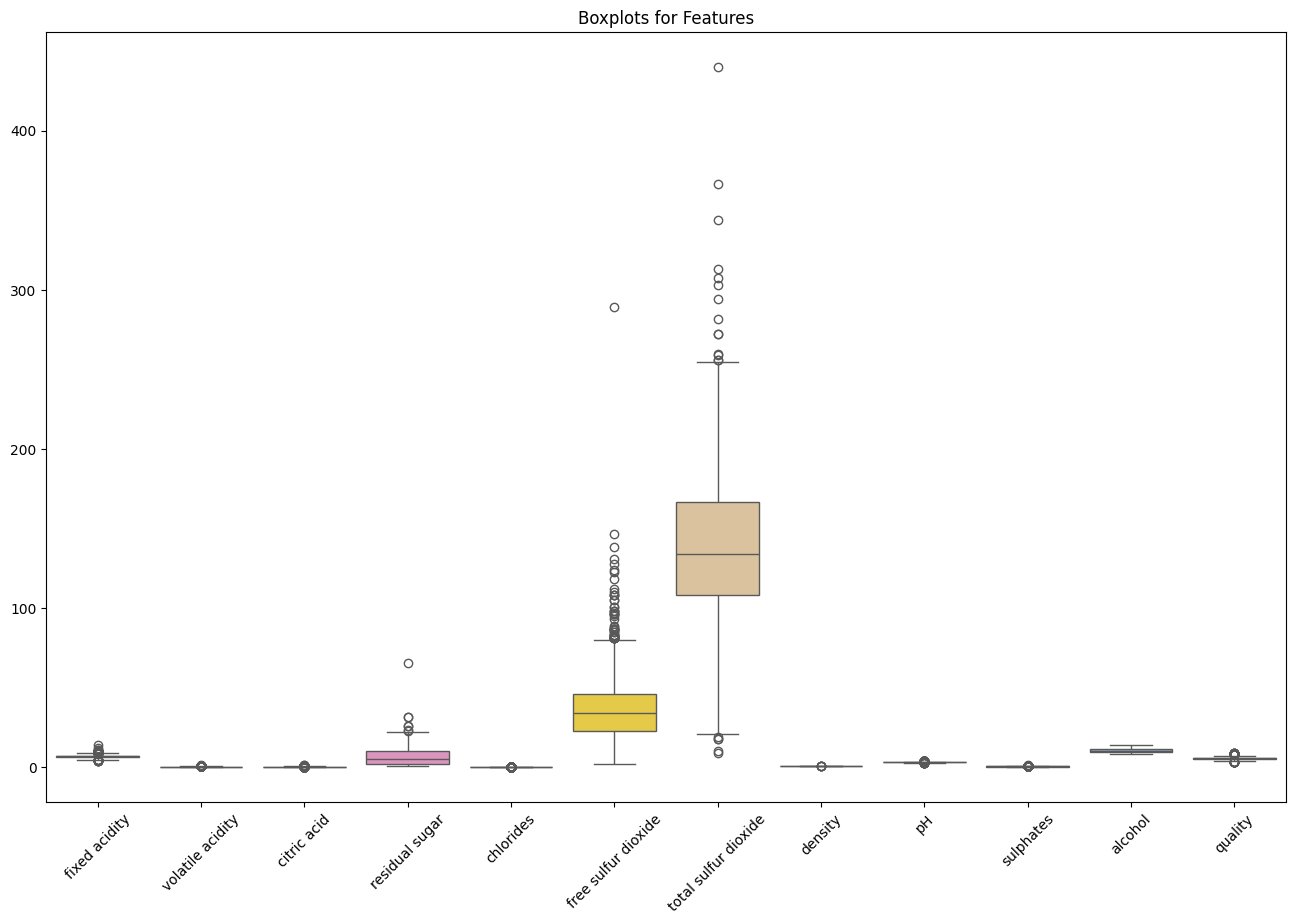

In [14]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=df, palette='Set2')
plt.title('Boxplots for Features')
plt.xticks(rotation=45)
plt.show()


z_scores = zscore(df.select_dtypes(include=['float64']))
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).all(axis=1)
df_no_outliers = df[~outliers]

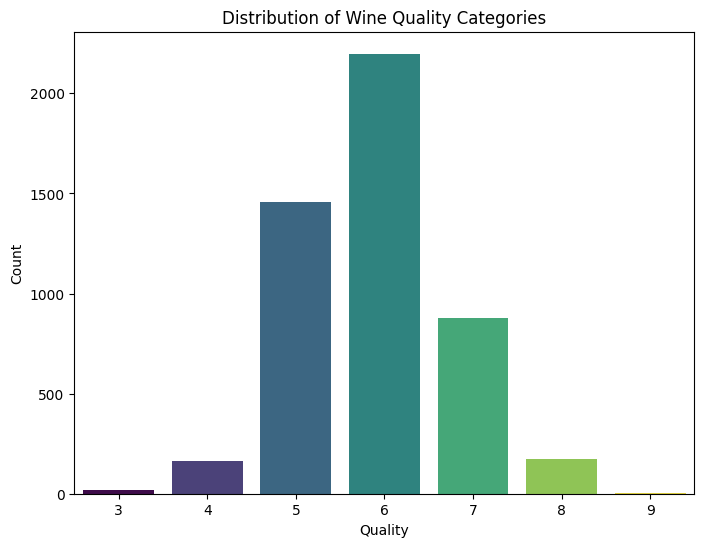

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64


In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', hue='quality', data=df, palette='viridis', legend=False)
plt.title('Distribution of Wine Quality Categories')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

print(df['quality'].value_counts())

In [16]:
print(X.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000         

In [17]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

print("Label Mapping:")
print(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=424242)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Label Mapping:
{3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6}
Shape of X_train: (3918, 11)
Shape of X_test: (980, 11)
Shape of y_train: (3918,)
Shape of y_test: (980,)


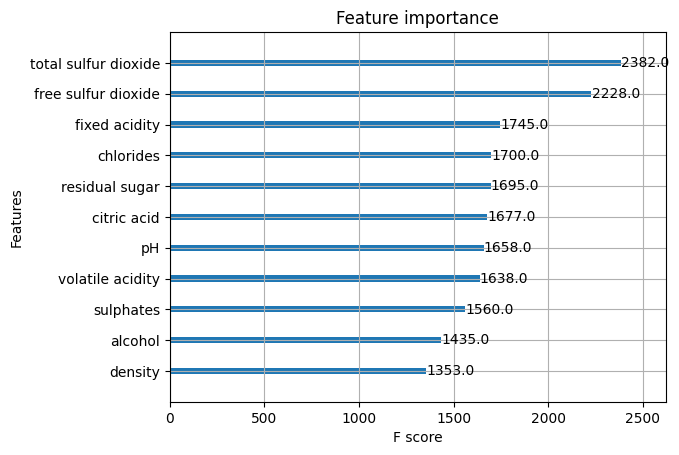

Best threshold: 0.042729079723358154
Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [18]:
import warnings
warnings.filterwarnings('ignore')   # <--- don't forget to remove this

import xgboost as xgb
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

smote = SMOTE(random_state=42, k_neighbors=2)  # decrease k_neighbors to 2

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_resampled, y_train_resampled)

plot_importance(xgb_classifier)
plt.show()

feature_importance = xgb_classifier.feature_importances_

# Use cross-validation to find the best threshold
thresholds = np.sort(feature_importance)
cv_scores = []
for thresh in thresholds:
    sfm = SelectFromModel(xgb_classifier, threshold=thresh, prefit=True)
    X_train_sfm = sfm.transform(X_train_resampled)
    scores = cross_val_score(xgb_classifier, X_train_sfm, y_train_resampled, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the threshold that gives the highest cross-validation score
best_thresh = thresholds[np.argmax(cv_scores)]
print(f"Best threshold: {best_thresh}")

# Select features based on importance
sfm = SelectFromModel(xgb_classifier, threshold=best_thresh)  # Use the best threshold
sfm.fit(X_train_resampled, y_train_resampled)

# Get selected features
selected_features = X_train.columns[sfm.get_support()]

# Display selected features
print("Selected Features:")
print(selected_features)

selected_features = X_train.columns[sfm.get_support()]


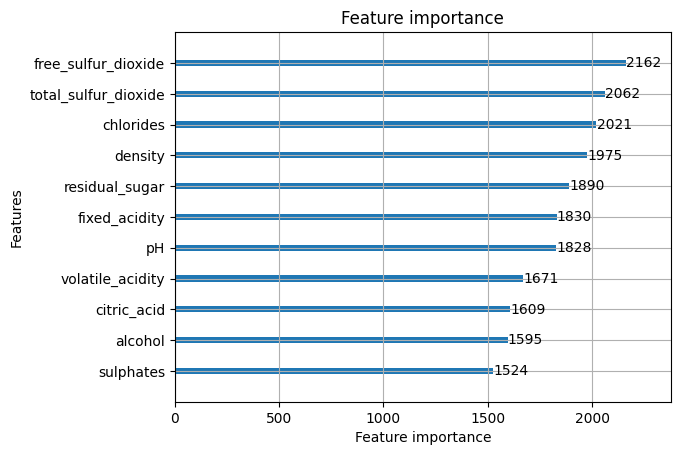

Selected Threshold: 0.1, Accuracy: 0.6693877551020408
Selected Threshold: 0.2, Accuracy: 0.6693877551020408
Selected Threshold: 0.25, Accuracy: 0.6693877551020408
Selected Threshold: 0.3, Accuracy: 0.6693877551020408
Selected Threshold: 0.4, Accuracy: 0.6693877551020408


In [19]:
import warnings
warnings.filterwarnings('ignore')   # <--- don't forget to remove this


import lightgbm as lgb
from lightgbm import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

lgb_classifier = lgb.LGBMClassifier(verbose=-1)

lgb_classifier.fit(X_train, y_train)

plot_importance(lgb_classifier)
plt.show()

feature_importance = lgb_classifier.feature_importances_

for threshold in [0.1, 0.2, 0.25, 0.3, 0.4]:
    sfm = SelectFromModel(lgb_classifier, threshold=threshold, prefit=True)  # Set prefit=True when model is already fitted
    sfm.fit(X_train, y_train)
    
    selected_features = X_train.columns[sfm.get_support()]
    
    lgb_classifier.fit(X_train[selected_features], y_train)
    
    y_pred = lgb_classifier.predict(X_test[selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Selected Threshold: {sfm.threshold_}, Accuracy: {accuracy}")


In [20]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} Classification Report:\n{report}\n")

xgb_model = XGBClassifier()
train_evaluate_model(xgb_model, X_train, y_train, X_test, y_test, "XGBoost")

lgbm_model = LGBMClassifier(verbosity=-1)
train_evaluate_model(lgbm_model, X_train, y_train, X_test, y_test, "LightGBM")


XGBoost Accuracy: 0.6551020408163265
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      0.26      0.38        35
           2       0.70      0.65      0.67       317
           3       0.62      0.78      0.69       417
           4       0.67      0.52      0.59       168
           5       0.81      0.37      0.51        35
           6       0.00      0.00      0.00         2

    accuracy                           0.66       980
   macro avg       0.51      0.37      0.41       980
weighted avg       0.66      0.66      0.64       980


LightGBM Accuracy: 0.6693877551020408
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.62      0.23      0.33        35
           2       0.72      0.66      0.69       317
           3       0.63      0.81      0.71    

In [21]:
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [22]:
import warnings
warnings.filterwarnings('ignore')   # <--- don't forget to remove this

xgb_model = xgb.XGBClassifier()
lgbm_model = LGBMClassifier(verbosity=-1)  # Set verbosity=-1 to suppress warning messages. don't forget
catboost_model = CatBoostClassifier()
gb_model = GradientBoostingClassifier()

xgb_params = {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'n_estimators': [50, 100]}
lgbm_params = {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'n_estimators': [50, 100]}
catboost_params = {'learning_rate': [0.01, 0.1], 'depth': [3, 5], 'n_estimators': [50, 100]}
gb_params = {'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'n_estimators': [50, 100]}

models = [(xgb_model, xgb_params), (lgbm_model, lgbm_params), (catboost_model, catboost_params), (gb_model, gb_params)]

for model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best accuracy score for {model.__class__.__name__}: {grid_search.best_score_}\n")


Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy score for XGBClassifier: 0.6217511142387989

Best parameters for LGBMClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy score for LGBMClassifier: 0.6283831156983866

0:	learn: 1.7903047	total: 161ms	remaining: 15.9s
1:	learn: 1.6806412	total: 167ms	remaining: 8.19s
2:	learn: 1.5958786	total: 173ms	remaining: 5.6s
3:	learn: 1.5279941	total: 180ms	remaining: 4.31s
4:	learn: 1.4714617	total: 186ms	remaining: 3.54s
5:	learn: 1.4212060	total: 192ms	remaining: 3.01s
6:	learn: 1.3818989	total: 198ms	remaining: 2.63s
7:	learn: 1.3454018	total: 205ms	remaining: 2.36s
8:	learn: 1.3130497	total: 211ms	remaining: 2.14s
9:	learn: 1.2852252	total: 219ms	remaining: 1.97s
10:	learn: 1.2604956	total: 224ms	remaining: 1.81s
11:	learn: 1.2368043	total: 230ms	remaining: 1.68s
12:	learn: 1.2171548	total: 236ms	remaining: 1.58s
13:	learn: 1.1998283	total: 243ms	rema

In [23]:
# - Old results to compare with:

# - Best parameters for CatBoostClassifier: {'depth': 7, 'learning_rate': 0.2, 'n_estimators': 200}
#   Best accuracy score for CatBoostClassifier: 0.6406403940886699
# - Best parameters for GradientBoostingClassifier: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
#   Best accuracy score for GradientBoostingClassifier: 0.6406403940886699
# - Best parameters for LGBMClassifier: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
#   Best accuracy score for LGBMClassifier: 0.6406403940886699


In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}

models = [(xgb_model, xgb_params), (lgbm_model, lgbm_params), (catboost_model, catboost_params), (gb_model, gb_params), (rf_model, rf_params)]

for model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best accuracy score for {model.__class__.__name__}: {grid_search.best_score_}\n")

Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy score for XGBClassifier: 0.6217511142387989

Best parameters for LGBMClassifier: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy score for LGBMClassifier: 0.6283831156983866

0:	learn: 1.7903047	total: 20ms	remaining: 1.98s
1:	learn: 1.6806412	total: 24.6ms	remaining: 1.2s
2:	learn: 1.5958786	total: 28.8ms	remaining: 930ms
3:	learn: 1.5279941	total: 33.5ms	remaining: 805ms
4:	learn: 1.4714617	total: 39ms	remaining: 741ms
5:	learn: 1.4212060	total: 43.8ms	remaining: 686ms
6:	learn: 1.3818989	total: 48.7ms	remaining: 647ms
7:	learn: 1.3454018	total: 54.1ms	remaining: 622ms
8:	learn: 1.3130497	total: 59.1ms	remaining: 598ms
9:	learn: 1.2852252	total: 63.9ms	remaining: 575ms
10:	learn: 1.2604956	total: 69.4ms	remaining: 562ms
11:	learn: 1.2368043	total: 74.4ms	remaining: 546ms
12:	learn: 1.2171548	total: 79ms	remaining: 529ms
13:	learn: 1.1998283	total: 84.

In [ ]:
# - At this point, thanks to my coding skills, this file takes 10 minutes to run. Which means, everytime I add something, I have to make a cup of tea :)
# - I have no clue how to fix imbalance. I tried to use SMOTE but it did not work. I am lost.
